### Predicting Employee Renege with Logistic Regression

There is a Bangalore based start-up providing talent acquisition solutions. An consultancy service agency advised it customers on talent acquisition practices and also implemented individually tailored solutions using analytics.
The no. of people not joining the company after accepting the offer varies from 15% to 35%. If a company rolls out thousand offers then the impact of renege is significant.

**Key Questions:**
What are the key drivers that influence the candidate joining/not-joining the company?
What rules can be used to predict the renege?
Devising a predictive algorithm to calculate the possibility of acceptance of an offer and joining the company after offer acceptance stage

**Problem Statement:**
Formulate a predictive algorithm to calculate the probability of acceptance of an offer and joining the company after acceptance stage.

A binomial logistic regression (often referred to simply as logistic regression), predicts the probability that an observation falls into one of two categories of a dichotomous dependent variable based on one or more independent variables that can be either continuous or categorical. 

In our case –
The Dependent Variable is “Status” of the candidate which is categorical –  Either the candidate will join or not join
And the Independent Variables are –  DOJ Extended, Duration to accept offer, Notice period, Offered band, Percent hike expected in CTC, Percent hike offered in CTC, Percent difference CTC, Joining Bonus, Candidate relocate actual, Gender, Candidate Source, Rex in Yrs, LOB, Location and Age

In [1]:
!pip install scikit-learn==0.23.1

     |████████████████████████████████| 6.9MB 2.6MB/s eta 0:00:01
     |████████████████████████████████| 307kB 8.1MB/s eta 0:00:01
  Found existing installation: scikit-learn 0.20.1
    Uninstalling scikit-learn-0.20.1:
      Successfully uninstalled scikit-learn-0.20.1


Let's first import required libraries:


In [3]:
import pandas as pd
import pylab as pl
import numpy as np
import scipy.optimize as opt
from sklearn import preprocessing
%matplotlib inline 
import matplotlib.pyplot as plt

### Load the Data Avilable

In [3]:
#Click here and press Shift+Enter
!wget -O ChurnData.csv https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%203/data/ChurnData.csv

--2021-06-13 12:14:35--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%203/data/ChurnData.csv
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.45.118.108
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|169.45.118.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35943 (35K) [text/csv]
Saving to: ‘ChurnData.csv’

ChurnData.csv       100%[===================>]  35.10K  --.-KB/s    in 0.07s   

2021-06-13 12:14:35 (505 KB/s) - ‘ChurnData.csv’ saved [35943/35943]



## Load Data From CSV File


In [4]:
hr_df = pd.read_csv("HRData.csv")
hr_df.head()

,CandidateRef,DOJEx,Duration,Notice,Band,PercentExpected,PercentOffered,PercentDiff,JoiningBonus,CandidateRelocate,Gender,CandidateSource,Experience,LOB,Location,Age,Status
0,2110407,1,14,30,2,-20.79,13.16,42.86,0,0,1,0,7,6,9,34,1
1,2112635,0,18,30,2,50.00,320.00,180.00,0,0,0,2,8,9,2,34,1
2,2112838,0,3,45,2,42.84,42.84,0.00,0,0,0,0,4,9,9,27,1
3,2115021,0,26,30,2,42.84,42.84,0.00,0,0,0,2,4,9,9,34,1
4,2115125,1,1,120,2,42.59,42.59,0.00,0,1,0,2,6,9,9,34,1


<h2 id="preprocessing">Data pre-processing and selection</h2>


Let's select some features for the modeling. Also, we change the target data type to be an integer, as it is a requirement by the skitlearn algorithm:


In [5]:
churn_df = churn_df[['tenure', 'age', 'address', 'income', 'ed', 'employ', 'equip',   'callcard', 'wireless','churn']]
churn_df['churn'] = churn_df['churn'].astype('int')
churn_df.head()

,tenure,age,address,income,ed,employ,equip,callcard,wireless,churn
0,11.0,33.0,7.0,136.0,5.0,5.0,0.0,1.0,1.0,1
1,33.0,33.0,12.0,33.0,2.0,0.0,0.0,0.0,0.0,1
2,23.0,30.0,9.0,30.0,1.0,2.0,0.0,0.0,0.0,0
3,38.0,35.0,5.0,76.0,2.0,10.0,1.0,1.0,1.0,0
4,7.0,35.0,14.0,80.0,2.0,15.0,0.0,1.0,0.0,0


## Practice

How many rows and columns are in this dataset in total? What are the names of columns?


In [5]:
# write your code here
hr_df.shape

(11430, 17)

Let's define X, and y for our dataset:


In [7]:
X = np.asarray(hr_df[['DOJEx', 'Duration', 'Notice', 'Band', 'PercentExpected', 'PercentOffered', 'PercentDiff', 'JoiningBonus', 'CandidateRelocate', 'Gender', 'CandidateSource', 'Experience', 'LOB', 'Location', 'Age']])
X[0:5]

array([[  1.  ,  14.  ,  30.  ,   2.  , -20.79,  13.16,  42.86,   0.  ,
          0.  ,   1.  ,   0.  ,   7.  ,   6.  ,   9.  ,  34.  ],
       [  0.  ,  18.  ,  30.  ,   2.  ,  50.  , 320.  , 180.  ,   0.  ,
          0.  ,   0.  ,   2.  ,   8.  ,   9.  ,   2.  ,  34.  ],
       [  0.  ,   3.  ,  45.  ,   2.  ,  42.84,  42.84,   0.  ,   0.  ,
          0.  ,   0.  ,   0.  ,   4.  ,   9.  ,   9.  ,  27.  ],
       [  0.  ,  26.  ,  30.  ,   2.  ,  42.84,  42.84,   0.  ,   0.  ,
          0.  ,   0.  ,   2.  ,   4.  ,   9.  ,   9.  ,  34.  ],
       [  1.  ,   1.  , 120.  ,   2.  ,  42.59,  42.59,   0.  ,   0.  ,
          1.  ,   0.  ,   2.  ,   6.  ,   9.  ,   9.  ,  34.  ]])

In [8]:
y = np.asarray(hr_df['Status'])
y [0:30]

array([1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1])

Also, we normalize the dataset:


In [9]:
from sklearn import preprocessing
X = preprocessing.StandardScaler().fit(X).transform(X)
X[0:15]

array([[ 1.16102836e+00, -1.15595712e-01, -3.21005489e-01,
         8.60746686e-01, -2.12282257e+00, -6.94490582e-01,
         2.24279516e+00, -2.16331129e-01, -3.71931224e-01,
         2.13146944e+00, -1.37273801e+00,  1.01815903e+00,
         1.70358966e-01,  1.31310386e+00,  8.94016767e-01],
       [-8.61305403e-01,  4.68208815e-02, -3.21005489e-01,
         8.60746686e-01,  2.75072743e-01,  7.93096207e+00,
         9.08568856e+00, -2.16331129e-01, -3.71931224e-01,
        -4.69159905e-01,  1.66744711e+00,  1.37868934e+00,
         1.14250224e+00, -6.99721640e-01,  8.94016767e-01],
       [-8.61305403e-01, -5.62241344e-01,  3.04692454e-01,
         8.60746686e-01,  3.25394689e-02,  1.39831653e-01,
         1.04203863e-01, -2.16331129e-01, -3.71931224e-01,
        -4.69159905e-01, -1.37273801e+00, -6.34318851e-02,
         1.14250224e+00,  1.31310386e+00, -8.01656510e-01],
       [-8.61305403e-01,  3.71654068e-01, -3.21005489e-01,
         8.60746686e-01,  3.25394689e-02,  1.39831653

## Train/Test dataset


We split our dataset into train and test set:


In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (9144, 15) (9144,)
Test set: (2286, 15) (2286,)


<h2 id="modeling">Modeling (Logistic Regression with Scikit-learn)</h2>


Let's build our model using **LogisticRegression** from the Scikit-learn package. This function implements logistic regression and can use different numerical optimizers to find parameters, including ‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’ solvers. You can find extensive information about the pros and cons of these optimizers if you search it in the internet.

The version of Logistic Regression in Scikit-learn, support regularization. Regularization is a technique used to solve the overfitting problem of machine learning models.
**C** parameter indicates **inverse of regularization strength** which must be a positive float. Smaller values specify stronger regularization.
Now let's fit our model with train set:


In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
LR

LogisticRegression(C=0.01, solver='liblinear')

Now we can predict using our test set:


In [12]:
yhat = LR.predict(X_test)
yhat

array([1, 1, 1, ..., 1, 1, 1])

**predict_proba**  returns estimates for all classes, ordered by the label of classes. So, the first column is the probability of class 0, P(Y=0|X), and second column is probability of class 1, P(Y=1|X):


In [13]:
yhat_prob = LR.predict_proba(X_test)
yhat_prob

array([[0.12788206, 0.87211794],
       [0.15079667, 0.84920333],
       [0.36995596, 0.63004404],
       ...,
       [0.28647002, 0.71352998],
       [0.11776492, 0.88223508],
       [0.31798411, 0.68201589]])

<h2 id="evaluation">Evaluation</h2>


### jaccard index

Let's try the jaccard index for accuracy evaluation. we can define jaccard as the size of the intersection divided by the size of the union of the two label sets. If the entire set of predicted labels for a sample strictly match with the true set of labels, then the subset accuracy is 1.0; otherwise it is 0.0.


In [14]:
from sklearn.metrics import jaccard_score
jaccard_score(y_test, yhat,pos_label=0)

0.2391891891891892

### confusion matrix

Another way of looking at the accuracy of the classifier is to look at **confusion matrix**.


In [19]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
print(confusion_matrix(y_test, yhat, labels=[1,0]))

[[1546   91]
 [ 472  177]]


Confusion matrix, without normalization
[[1546   91]
 [ 472  177]]


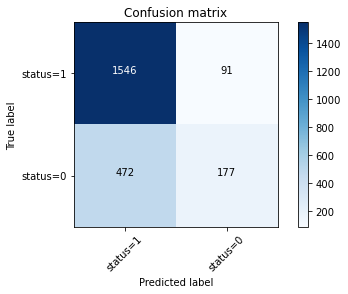

In [20]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[1,0])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['status=1','status=0'],normalize= False,  title='Confusion matrix')

The first row is for candidates whose actual status in the test set is 1 (Joined). As you can calculate, out of 2286 candidates, the status of 1637 of them is 1(Joined). Out of these 1637 cases, the classifier correctly predicted 1546 of them as 1 (Joined), and 91 of them as 0 (Not Joined).

This means, for 1546 candidates, the actual status was 1 (Joined) in test set and classifier also correctly predicted those as 1 (Joined). However, while the actual label of 91 customers was 1 (Joined), the classifier predicted those as 0 (Not Joined), which is particularly good. We can consider it as the error of the model for first row.

What about the candidates with status as 0 (Not Joined)? 
Let us look at the second row. It looks like there were 649 candidates whose churn value were 0 (Not Joined). The classifier correctly predicted 177 of them as 0 (Not Joined), and 472 of them wrongly as 1 (Joined). So, it has not done a good job in predicting the candidates with status as 0 (Not Joined).

 A good thing about the confusion matrix is that it shows the model’s ability to correctly predict or separate the classes. In a specific case of the binary classifier, such as this example, we can interpret these numbers as the count of true positives, false positives, true negatives, and false negatives.

In [21]:
print (classification_report(y_test, yhat))


              precision    recall  f1-score   support

           0       0.66      0.27      0.39       649
           1       0.77      0.94      0.85      1637

    accuracy                           0.75      2286
   macro avg       0.71      0.61      0.62      2286
weighted avg       0.74      0.75      0.72      2286



Based on the count of each section, we can calculate precision and recall of each label:

*   **Precision** is a measure of the accuracy provided that a class label has been predicted. It is defined by: precision = TP / (TP + FP)

*   **Recall** is the true positive rate. It is defined as: Recall =  TP / (TP + FN)

So, we can calculate the precision and recall of each class.

**F1 score:**
Now we are in the position to calculate the F1 scores for each label based on the precision and recall of that label.

The F1 score is the harmonic average of the precision and recall, where an F1 score reaches its best value at 1 (perfect precision and recall) and worst at 0. It is a good way to show that a classifer has a good value for both recall and precision.

Finally, we can tell the average accuracy for this classifier is the average of the F1-score for both labels, which is 0.72 in our case.


### log loss

Now, let's try **log loss** for evaluation. In logistic regression, the output can be the probability of customer churn is yes (or equals to 1). This probability is a value between 0 and 1.
Log loss( Logarithmic loss) measures the performance of a classifier where the predicted output is a probability value between 0 and 1.


In [22]:
from sklearn.metrics import log_loss
log_loss(y_test, yhat_prob)

0.49689392156665135

**LOG LOSS Value**

In [23]:
# write your code here
LR2 = LogisticRegression(C=0.01, solver='sag').fit(X_train,y_train)
yhat_prob2 = LR2.predict_proba(X_test)
print ("LogLoss: : %.2f" % log_loss(y_test, yhat_prob2))


LogLoss: : 0.50
